In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import os
# Read the CSV file into a DataFrame
df = pd.read_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Updated_p_df.csv')

# 1. Drop the first column `Unnamed: 0`
df.drop(columns=['Unnamed: 0'], inplace=True)

# 2. Convert `Date` column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 3. Function to convert match number (provided in the problem statement)
def convert_match_number(value):
    if value == 'Eliminator':
        return 1001  # Arbitrary unique high number
    elif value == 'Final':
        return 1002  # Arbitrary unique high number
    try:
        return int(value)
    except ValueError:
        return np.nan

# Apply the function and convert to numeric
df['Match Number'] = df['Match Number'].apply(convert_match_number)

# 4. Filter out null `Match Number`
df.dropna(subset = ['Match Number'], inplace=True)
df.isna().sum()


Date                                0
Match Number                        0
Season                              0
Gender                              0
Innings                             0
Toss Winner                         0
Toss Decision                       0
Match Winner                        0
Venue                               0
Player Team                         0
Team Against                        0
target                              0
Player Name                         0
Number of Runs Scored               0
Number of Balls Faced               0
4s                                  0
6s                                  0
Strike Rate                         0
Wicket Type                      1207
Number of Balls Bowled              0
Number of Runs Conceded             0
Economy                             0
Catches                             0
Run Outs                            0
Wicket Taken                        0
team_scores                         0
Player Total

In [4]:
# 1. Create new features
df['Batting_Contribution'] = (df['Player Strike Rate']/100) * df['Player Total Batting Average'] * df['Batsman Prob Score']
df['Bowling_Contribution'] = (df['Player Bowling Average'] * df['Bowler Prob Score']) * ( df['Bowler Aggregated Economy'])

# 2. Update Total_Player_Score
df['Total_Player_Score'] = df['Batting_Contribution'].fillna(0) + df['Bowling_Contribution'].fillna(0)

# 3. Fill missing values with 0
columns_to_fill = ['Player Strike Rate', 'Batsman Prob Score', 'Bowler Aggregated Economy', 'Bowler Prob Score']
for col in columns_to_fill:
    df[col].fillna(0, inplace=True)

# df[['Match Number', 'Season','Gender','Player Team','Player Name','Batting_Contribution', 'Bowling_Contribution']].head(11)

C:\Users\bhavi\AppData\Local\Temp\ipykernel_19204\471606621.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


In [5]:

# 4. Calculate team scores with innings filter
team1_scores = df[df['Innings'] == 1].groupby(['Match Number', 'Season', 'Gender', 'Player Team'])['Total_Player_Score'].sum().reset_index()
team2_scores = df[(df['Innings'] == 2) & (df['Team Against'] == df['Player Team'])].groupby(['Match Number', 'Season', 'Gender', 'Team Against'])['Total_Player_Score'].sum().reset_index()

# 5. Rename columns for merging
team1_scores.rename(columns={'Player Team': 'Team1', 'Total_Player_Score': 'Team1_Score'}, inplace=True)
team2_scores.rename(columns={'Team Against': 'Team2', 'Total_Player_Score': 'Team2_Score'}, inplace=True)


# Display the first 5 rows
# print(merged_df.head())

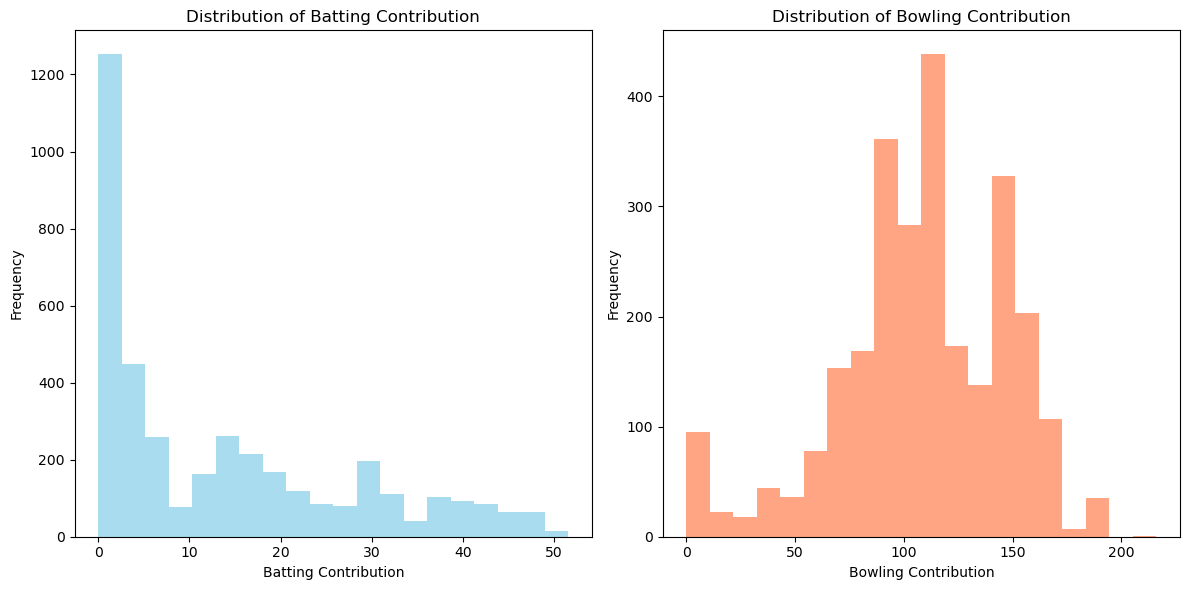

In [6]:
import matplotlib.pyplot as plt

# 12. Plot histograms for Batting_Contribution and Bowling_Contribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(df['Batting_Contribution'], bins=20, color='skyblue', alpha=0.7)
plt.title('Distribution of Batting Contribution')
plt.xlabel('Batting Contribution')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['Bowling_Contribution'], bins=20, color='coral', alpha=0.7)
plt.title('Distribution of Bowling Contribution')
plt.xlabel('Bowling Contribution')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Recalculate team2_scores with correct filtering
# First, create a mapping of Match Number, Season, Gender to Team Against from the first innings
first_innings_teams = df[df['Innings'] == 1][['Match Number', 'Season', 'Gender', 'Team Against']].drop_duplicates()

# Merge this mapping with the second innings data
second_innings_df = pd.merge(df[df['Innings'] == 2], first_innings_teams, on=['Match Number', 'Season', 'Gender'], how='left')


In [11]:
# Filter for rows where Player Team matches the Team Against from the first innings (using Team Against_y)
second_innings_df_filtered = second_innings_df[second_innings_df['Player Team'] == second_innings_df['Team Against_y']]

# Recalculate team2_scores
team2_scores = second_innings_df_filtered.groupby(['Match Number', 'Season', 'Gender', 'Player Team'])['Total_Player_Score'].sum().reset_index()

# Rename columns for merging
team2_scores.rename(columns={'Player Team': 'Team2', 'Total_Player_Score': 'Team2_Score'}, inplace=True)


In [12]:

# Merge the two dataframes
merged_df = pd.merge(team1_scores, team2_scores, on=['Match Number', 'Season', 'Gender'])

# Add target column (Match Winner)
merged_df = pd.merge(merged_df, df[['Match Number', 'Season', 'Gender', 'Match Winner']], on=['Match Number', 'Season', 'Gender'], how='left')

# Merge team stats with the merged dataframe
team_stats = df.groupby(['Season', 'Gender', 'Player Team'])[['Team Avg Score', 'Team Avg Economy', 'Player Team Win %', 'Team Scoring Prob Score', 'Team Economy Prob Score', 'Team Winning % Prob in Season', 'Player Team Probability Score']].mean().reset_index()

merged_df = pd.merge(merged_df, team_stats, left_on=['Season', 'Gender', 'Team1'], right_on=['Season', 'Gender', 'Player Team'], how='left')
merged_df = pd.merge(merged_df, team_stats, left_on=['Season', 'Gender', 'Team2'], right_on=['Season', 'Gender', 'Player Team'], how='left')

# Drop unnecessary columns and rename columns
merged_df.drop(columns=['Player Team_x', 'Player Team_y'], inplace=True)
merged_df.rename(columns={'Team Avg Score_x': 'Team1_Avg_Score',
                          'Team Avg Economy_x': 'Team1_Avg_Economy',
                          'Player Team Win %_x': 'Team1_Win_%',
                          'Team Scoring Prob Score_x': 'Team1_Scoring_Prob_Score',
                          'Team Economy Prob Score_x': 'Team1_Economy_Prob_Score',
                          'Team Winning % Prob in Season_x': 'Team1_Winning_Prob_in_Season',
                          'Player Team Probability Score_x': 'Team1_Probability_Score',
                          'Team Avg Score_y': 'Team2_Avg_Score',
                          'Team Avg Economy_y': 'Team2_Avg_Economy',
                          'Player Team Win %_y': 'Team2_Win_%',
                          'Team Scoring Prob Score_y': 'Team2_Scoring_Prob_Score',
                          'Team Economy Prob Score_y': 'Team2_Economy_Prob_Score',
                          'Team Winning % Prob in Season_y': 'Team2_Winning_Prob_in_Season',
                          'Player Team Probability Score_y': 'Team2_Probability_Score'}, inplace=True)

# Add new features
merged_df['Score_Diff'] = merged_df['Team1_Score'] - merged_df['Team2_Score']
merged_df['Win'] = merged_df.apply(lambda row: 1 if row['Match Winner'] == row['Team1'] else 0, axis=1)

# Print the number of rows in the updated team2_scores
print(f"Number of rows in the updated team2_scores: {len(team2_scores)}")

# Display the first 5 rows
print(merged_df.head())

Number of rows in the updated team2_scores: 181
   Match Number  Season  Gender                 Team1  Team1_Score  \
0             1    2021  female  Manchester Originals   712.252812   
1             1    2021  female  Manchester Originals   712.252812   
2             1    2021  female  Manchester Originals   712.252812   
3             1    2021  female  Manchester Originals   712.252812   
4             1    2021  female  Manchester Originals   712.252812   

              Team2  Team2_Score      Match Winner  Team1_Avg_Score  \
0  Oval Invincibles   812.180826  Oval Invincibles           117.57   
1  Oval Invincibles   812.180826  Oval Invincibles           117.57   
2  Oval Invincibles   812.180826  Oval Invincibles           117.57   
3  Oval Invincibles   812.180826  Oval Invincibles           117.57   
4  Oval Invincibles   812.180826  Oval Invincibles           117.57   

   Team1_Avg_Economy  ...  Team1_Probability_Score  Team2_Avg_Score  \
0               7.72  ...        

In [17]:
import pandas as pd
from prettytable import PrettyTable
import csv

# Assuming 'df' is your first DataFrame and 'merged_df' is your second DataFrame
# List of features to compare
player_features = ['Batting_Contribution', 'Bowling_Contribution', 'Total_Player_Score']
team_features = ['Score_Diff', 'Team1_Win_%', 'Team1_Probability_Score', 'Team1_Avg_Score']

# Function to calculate statistics for a feature
def calculate_stats(data):
    return {
        'Mean': data.mean(),
        'Median': data.median(),
        'Std Dev': data.std(),
        'Min': data.min(),
        'Max': data.max(),
        'IQR': data.quantile(0.75) - data.quantile(0.25)
    }

# Create a PrettyTable object
table = PrettyTable()
table.field_names = ["Feature", "Statistic", "Male", "Female"]

# Calculate and add rows to the table for player-level features
for feature in player_features:
    male_stats = calculate_stats(df[df['Gender'] == 'male'][feature])
    female_stats = calculate_stats(df[df['Gender'] == 'female'][feature])
    
    for stat in ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'IQR']:
        table.add_row([
            feature,
            stat,
            f"{male_stats[stat]:.2f}",
            f"{female_stats[stat]:.2f}"
        ])
    
    # Add a blank row for readability
    table.add_row([''] * 4)

# Calculate and add rows to the table for team-level features
for feature in team_features:
    male_stats = calculate_stats(merged_df[merged_df['Gender'] == 'male'][feature])
    female_stats = calculate_stats(merged_df[merged_df['Gender'] == 'female'][feature])
    
    for stat in ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'IQR']:
        table.add_row([
            feature,
            stat,
            f"{male_stats[stat]:.2f}",
            f"{female_stats[stat]:.2f}"
        ])
    
    # Add a blank row for readability
    table.add_row([''] * 4)

# Print the table
print(table)

# Export the table to a CSV file
with open('feature_comparison.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(table.field_names)
    for row in table._rows:
        csv_writer.writerow(row)

print("Table exported to 'feature_comparison.csv'")

+-------------------------+-----------+---------+---------+
|         Feature         | Statistic |   Male  |  Female |
+-------------------------+-----------+---------+---------+
|   Batting_Contribution  |    Mean   |  15.07  |  11.91  |
|   Batting_Contribution  |   Median  |  13.48  |   5.19  |
|   Batting_Contribution  |  Std Dev  |  14.37  |  13.45  |
|   Batting_Contribution  |    Min    |   0.00  |   0.00  |
|   Batting_Contribution  |    Max    |  51.59  |  51.34  |
|   Batting_Contribution  |    IQR    |  23.33  |  19.58  |
|                         |           |         |         |
|   Bowling_Contribution  |    Mean   |  128.72 |  87.98  |
|   Bowling_Contribution  |   Median  |  140.38 |  94.08  |
|   Bowling_Contribution  |  Std Dev  |  35.00  |  30.96  |
|   Bowling_Contribution  |    Min    |   2.92  |   0.00  |
|   Bowling_Contribution  |    Max    |  216.16 |  162.85 |
|   Bowling_Contribution  |    IQR    |  41.85  |  33.72  |
|                         |           | 

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Define features and target
X = merged_df[['Score_Diff',
               'Team1_Avg_Score', 'Team1_Avg_Economy', 'Team1_Win_%',
               'Team1_Scoring_Prob_Score', 'Team1_Economy_Prob_Score',
               'Team1_Winning_Prob_in_Season', 'Team1_Probability_Score',
               'Team2_Avg_Score', 'Team2_Avg_Economy', 'Team2_Win_%',
               'Team2_Scoring_Prob_Score', 'Team2_Economy_Prob_Score',
               'Team2_Winning_Prob_in_Season', 'Team2_Probability_Score']]
y = merged_df['Win']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
logloss_rf = log_loss(y_test, y_pred_prob_rf)
accuracy_rf = accuracy_score(y_test, y_pred_prob_rf.round())
precision_rf = precision_score(y_test, y_pred_prob_rf.round())
recall_rf = recall_score(y_test, y_pred_prob_rf.round())
f1_rf = f1_score(y_test, y_pred_prob_rf.round())
auc_rf = roc_auc_score(y_test, y_pred_prob_rf.round())

print("Random Forest Metrics:")
print(f"Log Loss: {logloss_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC-ROC: {auc_rf:.4f}")

# Train SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict
y_pred_prob_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluate SVM
logloss_svm = log_loss(y_test, y_pred_prob_svm.round())
accuracy_svm = accuracy_score(y_test, y_pred_prob_svm.round())
precision_svm = precision_score(y_test, y_pred_prob_svm.round())
recall_svm = recall_score(y_test, y_pred_prob_svm.round())
f1_svm = f1_score(y_test, y_pred_prob_svm.round())
auc_svm = roc_auc_score(y_test, y_pred_prob_svm.round())

print("\nSVM Metrics:")
print(f"Log Loss: {logloss_svm:.4f}")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print(f"AUC-ROC: {auc_svm:.4f}")

Random Forest Metrics:
Log Loss: 0.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000

SVM Metrics:
Log Loss: 7.7333
Accuracy: 0.7854
Precision: 0.7819
Recall: 0.7955
F1 Score: 0.7886
AUC-ROC: 0.7854


In [20]:
# Update the predict_match_outcome function to use the rf_model
def predict_match_outcome(team1, team2, players1, players2, gender):

    # Filter data for the given gender and most recent season
    filtered_df = df[(df['Gender'] == gender) & (df['Season'] == 2023)]

    # Calculate average Total_Player_Score for each player, filling missing values with 0
    player_scores1 = filtered_df[filtered_df['Player Name'].isin(players1)].groupby('Player Name')['Total_Player_Score'].mean().fillna(0)
    player_scores2 = filtered_df[filtered_df['Player Name'].isin(players2)].groupby('Player Name')['Total_Player_Score'].mean().fillna(0)

    # Handle new players
    avg_score_team1 = filtered_df[(filtered_df['Player Team']== team1) & (filtered_df['Gender'] == gender) ]['Total_Player_Score'].mean()
    avg_score_team2 = filtered_df[(filtered_df['Player Team']== team2) & (filtered_df['Gender'] == gender) ]['Total_Player_Score'].mean()


    for player in players1:
        if player not in player_scores1.index:
            player_scores1[player] = avg_score_team1

    for player in players2:
        if player not in player_scores2.index:
            player_scores2[player] = avg_score_team2

    # Calculate total team scores
    team1_score = player_scores1.sum()
    team2_score = player_scores2.sum()

    # Get team-level statistics with checks
    team1_stats_query = team_stats[(team_stats['Gender'] == gender) & (team_stats['Player Team'] == team1)]
    team2_stats_query = team_stats[(team_stats['Gender'] == gender) & (team_stats['Player Team'] == team2)]

    if team1_stats_query.empty:
        raise ValueError(f"No stats found for team {team1} in {gender} league")
    if team2_stats_query.empty:
        raise ValueError(f"No stats found for team {team2} in {gender} league")

    # team1_stats = team1_stats_query.iloc[0]
    # team2_stats = team2_stats_query.iloc[0]
    team1_stats = team1_stats_query.select_dtypes(include=['number']).drop(columns=['Season'])
    team2_stats = team2_stats_query.select_dtypes(include=['number']).drop(columns=['Season'])
    
    # Fill missing team stats with median (without inplace=True)
    team1_stats_filled = team1_stats # .fillna(team_stats.median())
    team2_stats_filled = team2_stats # .fillna(team_stats.median())

    team1_stats_filled = team1_stats.mean() # .fillna(team_stats.median())
    team2_stats_filled = team2_stats.mean()
    
    # Create new match data using the filled stats
    new_match_data = pd.DataFrame({
        'Score_Diff': [team1_score - team2_score],
        'Team1_Avg_Score': [team1_stats_filled['Team Avg Score']],
        'Team1_Avg_Economy': [team1_stats_filled['Team Avg Economy']],
        'Team1_Win_%': [team1_stats_filled['Player Team Win %']],
        'Team1_Scoring_Prob_Score': [team1_stats_filled['Team Scoring Prob Score']],
        'Team1_Economy_Prob_Score': [team1_stats_filled['Team Economy Prob Score']],
        'Team1_Winning_Prob_in_Season': [team1_stats_filled['Team Winning % Prob in Season']],
        'Team1_Probability_Score': [team1_stats_filled['Player Team Probability Score']],
        'Team2_Avg_Score': [team2_stats_filled['Team Avg Score']],
        'Team2_Avg_Economy': [team2_stats_filled['Team Avg Economy']],
        'Team2_Win_%': [team2_stats_filled['Player Team Win %']],
        'Team2_Scoring_Prob_Score': [team2_stats_filled['Team Scoring Prob Score']],
        'Team2_Economy_Prob_Score': [team2_stats_filled['Team Economy Prob Score']],
        'Team2_Winning_Prob_in_Season': [team2_stats_filled['Team Winning % Prob in Season']],
        'Team2_Probability_Score': [team2_stats_filled['Player Team Probability Score']]
    })

    # Predict using rf_model
    team1_win_prob = rf_model.predict_proba(new_match_data)[:, 1][0]
    team2_win_prob = svm_model.predict_proba(new_match_data)[:, 1][0]
    
    # Return probabilities
    return {'team1_win_prob': team1_win_prob, 'team2_win_prob': 1 - team1_win_prob, 'team1_win_svm': team2_win_prob, 'team2_win_svm': 1 - team2_win_prob,}

# Example usage with provided values
team1 = "Oval Invincibles"
team2 = "Manchester Originals"
players1 = ["JJ Roy", "WG Jacks", "PR Stirling", "SM Curran", "SW Billings", "JDS Neesham", "TK Curran", "RA Whiteley", "AAP Atkinson", "NA Sowter", "DR Briggs"]
players2 = ["PD Salt", "JC Buttler", "MDE Holden", "WL Madsen", "LJ Evans", "PI Walter", "J Overton", "TW Hartley", "J Little", "Zaman Khan", "RJ Gleeson"]
gender = "male"

# Predict and print results
result = predict_match_outcome(team1, team2, players1, players2, gender)
print(f"Win probability for {team1}: {result['team1_win_prob']:.4f}")
print(f"Win probability for {team2}: {result['team2_win_prob']:.4f}")
print(f"Win probability for {team1} using SVM: {result['team1_win_svm']:.4f}")
print(f"Win probability for {team2} using SVM: {result['team2_win_svm']:.4f}")


Win probability for Oval Invincibles: 0.5600
Win probability for Manchester Originals: 0.4400
Win probability for Oval Invincibles using SVM: 0.7625
Win probability for Manchester Originals using SVM: 0.2375


In [21]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for the Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node   
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2)

# Fit the GridSearchCV object to the data for Random Forest
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best score for Random Forest
print("Random Forest Best Parameters: ", grid_search_rf.best_params_)
print("Random Forest Best Score: ", grid_search_rf.best_score_)

# Use the best estimator for predictions
best_rf_model = grid_search_rf.best_estimator_

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Standardize the data and use SVM in a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('svm', svm_model)
])

# Define the hyperparameter grid for SVM
param_grid_svm = {
    'svm__C': [0.1, 1, 10],  
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

# Create a GridSearchCV object for SVM with parallel processing
grid_search_svm = GridSearchCV(estimator=pipeline, param_grid=param_grid_svm, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the GridSearchCV object to the data for SVM
grid_search_svm.fit(X_train, y_train)

# Print the best parameters and best score for SVM
print("\nSVM Best Parameters (after hyperparameter tuning): ", grid_search_svm.best_params_)
print("SVM Best Score: ", grid_search_svm.best_score_)

# Use the best SVM estimator for predictions
best_svm_model = grid_search_svm.best_estimator_





Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_dep

In [177]:
# Predict
y_pred_prob_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluate Random Forest
logloss_best_rf = log_loss(y_test, y_pred_prob_best_rf)
accuracy_best_rf = accuracy_score(y_test, y_pred_prob_best_rf)
precision_best_rf = precision_score(y_test, y_pred_prob_best_rf)
recall_best_rf = recall_score(y_test, y_pred_prob_best_rf)
f1_best_rf = f1_score(y_test, y_pred_prob_best_rf)
auc_best_rf = roc_auc_score(y_test, y_pred_prob_best_rf)

print("\nRandom Forest Evaluation (after hyperparameter tuning):")
print(f"Log Loss: {logloss_best_rf:.4f}")
print(f"Accuracy: {accuracy_best_rf:.4f}")
print(f"Precision: {precision_best_rf:.4f}")
print(f"Recall: {recall_best_rf:.4f}")
print(f"F1 Score: {f1_best_rf:.4f}")
print(f"AUC-ROC: {auc_best_rf:.4f}")

# Predict
y_pred_prob_best_svm = best_svm_model.predict_proba(X_test)[:, 1]

# Evaluate SVM
logloss_best_svm = log_loss(y_test, y_pred_prob_best_svm.round())
accuracy_best_svm = accuracy_score(y_test, y_pred_prob_best_svm.round())
precision_best_svm = precision_score(y_test, y_pred_prob_best_svm.round())
recall_best_svm = recall_score(y_test, y_pred_prob_best_svm.round())
f1_best_svm = f1_score(y_test, y_pred_prob_best_svm.round())
auc_best_svm = roc_auc_score(y_test, y_pred_prob_best_svm.round())

print("\nSVM Evaluation (after hyperparameter tuning):")
print(f"Log Loss: {logloss_best_svm:.4f}")
print(f"Accuracy: {accuracy_best_svm:.4f}")
print(f"Precision: {precision_best_svm:.4f}")
print(f"Recall: {recall_best_svm:.4f}")
print(f"F1 Score: {f1_best_svm:.4f}")
print(f"AUC-ROC: {auc_best_svm:.4f}")


Random Forest Evaluation (after hyperparameter tuning):
Log Loss: 0.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AUC-ROC: 1.0000

SVM Evaluation (after hyperparameter tuning):
Log Loss: 0.5427
Accuracy: 0.9849
Precision: 0.9709
Recall: 1.0000
F1 Score: 0.9853
AUC-ROC: 0.9848


In [178]:
# Results for 2024 Matches with Models Random Forest and SVM without hypertuning
pdf = pd.read_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\hundreds_extracted_data_with_match_stats.csv')
rf_right_results = 0
rf_incorrect_results = 0
svm_right_results = 0
svm_incorrect_results = 0
for j in pdf['Gender'].unique():
    
    for i in pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j)]['Match Number'].unique():
        team1 = pdf[(pdf['Season'] == 2024) &  (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 1 ) ]['Player Team'].unique()[0]
        team2 = pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 2 ) ]['Player Team'].unique()[0]
        
        players1 = list(pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 1 ) ]['Player Name'].unique())
        players2 = list(pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 2 ) ]['Player Name'].unique())
        gender = j
        match_winner = pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) ]['Match Winner'].unique()[0]
        result = predict_match_outcome(team1, team2, players1, players2, gender)
        # print(f"Win probability for {team1} using Random Forest: {result['team1_win_prob']:.4f}")
        # print(f"Win probability for {team2} using Random Forest: {result['team2_win_prob']:.4f}")
        # print(f"Win probability for {team1} using SVM: {result['team1_win_svm']:.4f}")
        # print(f"Win probability for {team2} using SVM: {result['team2_win_svm']:.4f}")
        if result['team1_win_prob'] > result['team2_win_prob'] :
            rf_predicted_winner = team1
        else :
            rf_predicted_winner = team2
        if match_winner == rf_predicted_winner:
            rf_right_results += 1
        elif match_winner == 'no result':
            pass
        else:
            rf_incorrect_results += 1
        if result['team1_win_svm'] > result['team2_win_svm'] :
            svm_predicted_winner = team1
        else :
            svm_predicted_winner = team2
        if match_winner == svm_predicted_winner:
            svm_right_results += 1
        elif match_winner == 'no result':
            pass
        else:
            svm_incorrect_results += 1
        
        # print(f"Match Number {i}, Gender: {j}, Season: 2024, Actual Winner : {match_winner} ")
        # print(f"Rf Predicted Results for {team1} : {result['team1_win_prob']:.4f}, {team2} : {result['team2_win_prob']:.4f} ")
        # print(f"Rf Predicted Winner : {rf_predicted_winner} ")
        # print(f"SVM Predicted Results for {team1} : {result['team1_win_svm']:.4f}, {team2} : {result['team2_win_svm']:.4f} ")
        # print(f"SVM Predicted Winner : {svm_predicted_winner} {'\n'}", )
    print( f"For {j} \nRF Right Results: {rf_right_results} Out of {rf_right_results + rf_incorrect_results}")
    print( f"SVM Right Results: {svm_right_results} Out of {svm_right_results + svm_incorrect_results}")
    rf_right_results = 0
    rf_incorrect_results = 0
    svm_right_results = 0
    svm_incorrect_results = 0

For male 
RF Right Results: 23 Out of 32
SVM Right Results: 16 Out of 32
For female 
RF Right Results: 15 Out of 32
SVM Right Results: 14 Out of 32


In [179]:
# Update the predict_match_outcome function to use the rf_model
def predict_match_outcome(team1, team2, players1, players2, gender):

    # Filter data for the given gender and most recent season
    filtered_df = df[(df['Gender'] == gender) & (df['Season'] == 2023)]

    # Calculate average Total_Player_Score for each player, filling missing values with 0
    player_scores1 = filtered_df[filtered_df['Player Name'].isin(players1)].groupby('Player Name')['Total_Player_Score'].mean().fillna(0)
    player_scores2 = filtered_df[filtered_df['Player Name'].isin(players2)].groupby('Player Name')['Total_Player_Score'].mean().fillna(0)

    # Handle new players
    avg_score_team1 = filtered_df[(filtered_df['Player Team']== team1) & (filtered_df['Gender'] == gender) ]['Total_Player_Score'].mean()
    avg_score_team2 = filtered_df[(filtered_df['Player Team']== team2) & (filtered_df['Gender'] == gender) ]['Total_Player_Score'].mean()


    for player in players1:
        if player not in player_scores1.index:
            player_scores1[player] = avg_score_team1

    for player in players2:
        if player not in player_scores2.index:
            player_scores2[player] = avg_score_team2

    # Calculate total team scores
    team1_score = player_scores1.sum()
    team2_score = player_scores2.sum()

    # Get team-level statistics with checks
    team1_stats_query = team_stats[(team_stats['Gender'] == gender) & (team_stats['Player Team'] == team1)]
    team2_stats_query = team_stats[(team_stats['Gender'] == gender) & (team_stats['Player Team'] == team2)]

    if team1_stats_query.empty:
        raise ValueError(f"No stats found for team {team1} in {gender} league")
    if team2_stats_query.empty:
        raise ValueError(f"No stats found for team {team2} in {gender} league")

    # team1_stats = team1_stats_query.iloc[0]
    # team2_stats = team2_stats_query.iloc[0]
    team1_stats = team1_stats_query.select_dtypes(include=['number']).drop(columns=['Season'])
    team2_stats = team2_stats_query.select_dtypes(include=['number']).drop(columns=['Season'])
    
    # Fill missing team stats with median (without inplace=True)
    team1_stats_filled = team1_stats # .fillna(team_stats.median())
    team2_stats_filled = team2_stats # .fillna(team_stats.median())

    team1_stats_filled = team1_stats.mean() # .fillna(team_stats.median())
    team2_stats_filled = team2_stats.mean()
    
    # Create new match data using the filled stats
    new_match_data = pd.DataFrame({
        'Score_Diff': [team1_score - team2_score],
        'Team1_Avg_Score': [team1_stats_filled['Team Avg Score']],
        'Team1_Avg_Economy': [team1_stats_filled['Team Avg Economy']],
        'Team1_Win_%': [team1_stats_filled['Player Team Win %']],
        'Team1_Scoring_Prob_Score': [team1_stats_filled['Team Scoring Prob Score']],
        'Team1_Economy_Prob_Score': [team1_stats_filled['Team Economy Prob Score']],
        'Team1_Winning_Prob_in_Season': [team1_stats_filled['Team Winning % Prob in Season']],
        'Team1_Probability_Score': [team1_stats_filled['Player Team Probability Score']],
        'Team2_Avg_Score': [team2_stats_filled['Team Avg Score']],
        'Team2_Avg_Economy': [team2_stats_filled['Team Avg Economy']],
        'Team2_Win_%': [team2_stats_filled['Player Team Win %']],
        'Team2_Scoring_Prob_Score': [team2_stats_filled['Team Scoring Prob Score']],
        'Team2_Economy_Prob_Score': [team2_stats_filled['Team Economy Prob Score']],
        'Team2_Winning_Prob_in_Season': [team2_stats_filled['Team Winning % Prob in Season']],
        'Team2_Probability_Score': [team2_stats_filled['Player Team Probability Score']]
    })

    # Predict using rf_model
    team1_win_prob = best_rf_model.predict_proba(new_match_data)[:, 1][0]
    team2_win_prob = best_svm_model.predict_proba(new_match_data)[:, 1][0]
    
    # Return probabilities
    return {'team1_win_prob': team1_win_prob, 'team2_win_prob': 1 - team1_win_prob, 'team1_win_svm': team2_win_prob, 'team2_win_svm': 1 - team2_win_prob,}

# Example usage with provided values
team1 = "Oval Invincibles"
team2 = "Manchester Originals"
players1 = ["JJ Roy", "WG Jacks", "PR Stirling", "SM Curran", "SW Billings", "JDS Neesham", "TK Curran", "RA Whiteley", "AAP Atkinson", "NA Sowter", "DR Briggs"]
players2 = ["PD Salt", "JC Buttler", "MDE Holden", "WL Madsen", "LJ Evans", "PI Walter", "J Overton", "TW Hartley", "J Little", "Zaman Khan", "RJ Gleeson"]
gender = "male"

# Predict and print results
result = predict_match_outcome(team1, team2, players1, players2, gender)
print(f"Win probability for {team1}: {result['team1_win_prob']:.4f}")
print(f"Win probability for {team2}: {result['team2_win_prob']:.4f}")
print(f"Win probability for {team1} using SVM: {result['team1_win_svm']:.4f}")
print(f"Win probability for {team2} using SVM: {result['team2_win_svm']:.4f}")


Win probability for Oval Invincibles: 0.5400
Win probability for Manchester Originals: 0.4600
Win probability for Oval Invincibles using SVM: 0.0001
Win probability for Manchester Originals using SVM: 0.9999


In [180]:
# Results for 2024 Matches with Hypertuned Models Random Forest and SVM 
pdf = pd.read_csv('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\hundreds_extracted_data_with_match_stats.csv')
rf_right_results = 0
rf_incorrect_results = 0
svm_right_results = 0
svm_incorrect_results = 0
for j in pdf['Gender'].unique():
    
    for i in pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j)]['Match Number'].unique():
        team1 = pdf[(pdf['Season'] == 2024) &  (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 1 ) ]['Player Team'].unique()[0]
        team2 = pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 2 ) ]['Player Team'].unique()[0]
        
        players1 = list(pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 1 ) ]['Player Name'].unique())
        players2 = list(pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) & (pdf['Innings'] == 2 ) ]['Player Name'].unique())
        gender = j
        match_winner = pdf[(pdf['Season'] == 2024) & (pdf['Gender'] == j) & (pdf['Match Number'] == str(i)) ]['Match Winner'].unique()[0]
        result = predict_match_outcome(team1, team2, players1, players2, gender)
        # print(f"Win probability for {team1} using Random Forest: {result['team1_win_prob']:.4f}")
        # print(f"Win probability for {team2} using Random Forest: {result['team2_win_prob']:.4f}")
        # print(f"Win probability for {team1} using SVM: {result['team1_win_svm']:.4f}")
        # print(f"Win probability for {team2} using SVM: {result['team2_win_svm']:.4f}")
        if result['team1_win_prob'] > result['team2_win_prob'] :
            rf_predicted_winner = team1
        else :
            rf_predicted_winner = team2
        if match_winner == rf_predicted_winner:
            rf_right_results += 1
        elif match_winner == 'no result':
            pass
        else:
            rf_incorrect_results += 1
        if result['team1_win_svm'] > result['team2_win_svm'] :
            svm_predicted_winner = team1
        else :
            svm_predicted_winner = team2
        if match_winner == svm_predicted_winner:
            svm_right_results += 1
        elif match_winner == 'no result':
            pass
        else:
            svm_incorrect_results += 1
        
        # print(f"Match Number {i}, Gender: {j}, Season: 2024, Actual Winner : {match_winner} ")
        # print(f"Rf Predicted Results for {team1} : {result['team1_win_prob']:.4f}, {team2} : {result['team2_win_prob']:.4f} ")
        # print(f"Rf Predicted Winner : {rf_predicted_winner} ")
        # print(f"SVM Predicted Results for {team1} : {result['team1_win_svm']:.4f}, {team2} : {result['team2_win_svm']:.4f} ")
        # print(f"SVM Predicted Winner : {svm_predicted_winner} {'\n'}", )
    print( f"For {j} \nRF Right Results: {rf_right_results} Out of {rf_right_results + rf_incorrect_results}")
    print( f"SVM Right Results: {svm_right_results} Out of {svm_right_results + svm_incorrect_results}")
    rf_right_results = 0
    rf_incorrect_results = 0
    svm_right_results = 0
    svm_incorrect_results = 0

For male 
RF Right Results: 23 Out of 32
SVM Right Results: 24 Out of 32
For female 
RF Right Results: 14 Out of 32
SVM Right Results: 14 Out of 32


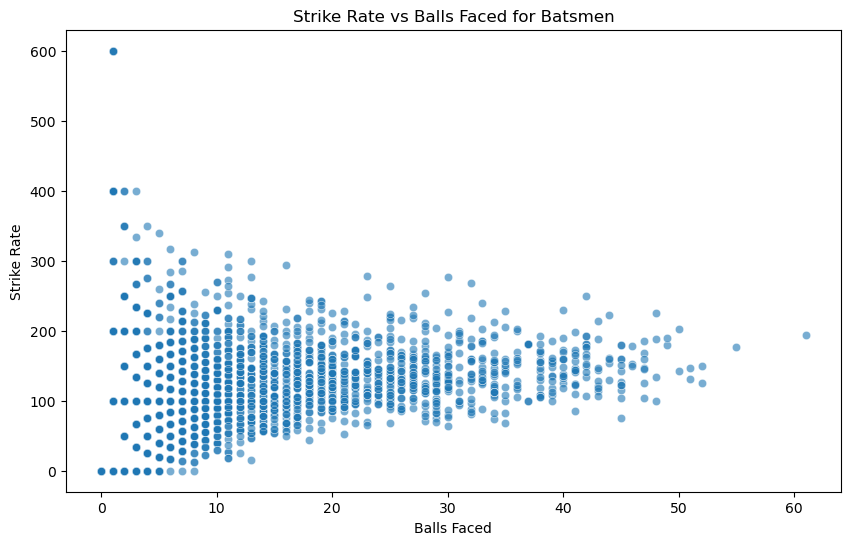

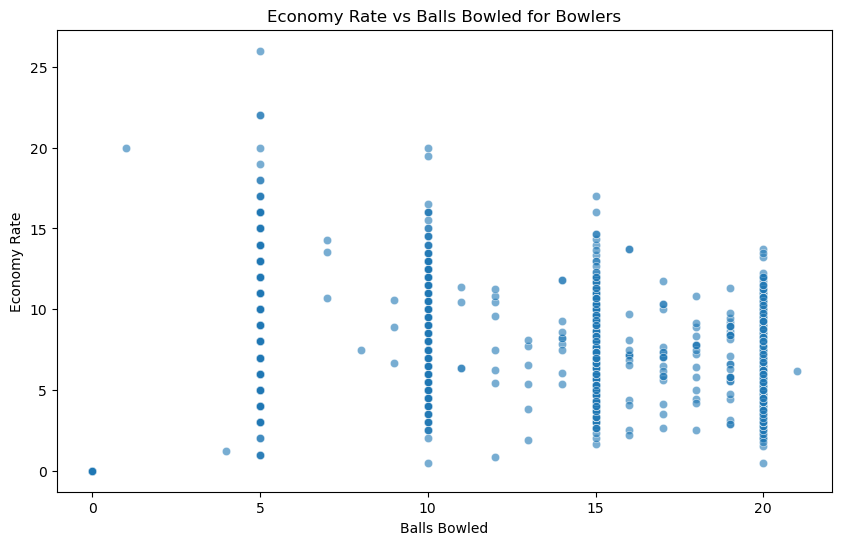

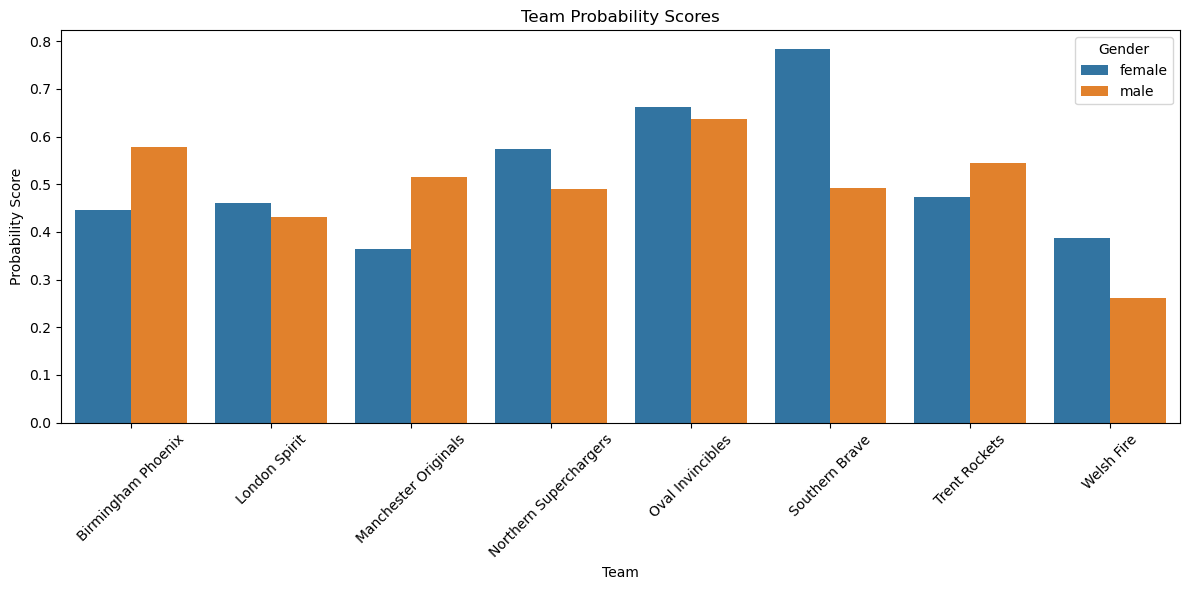

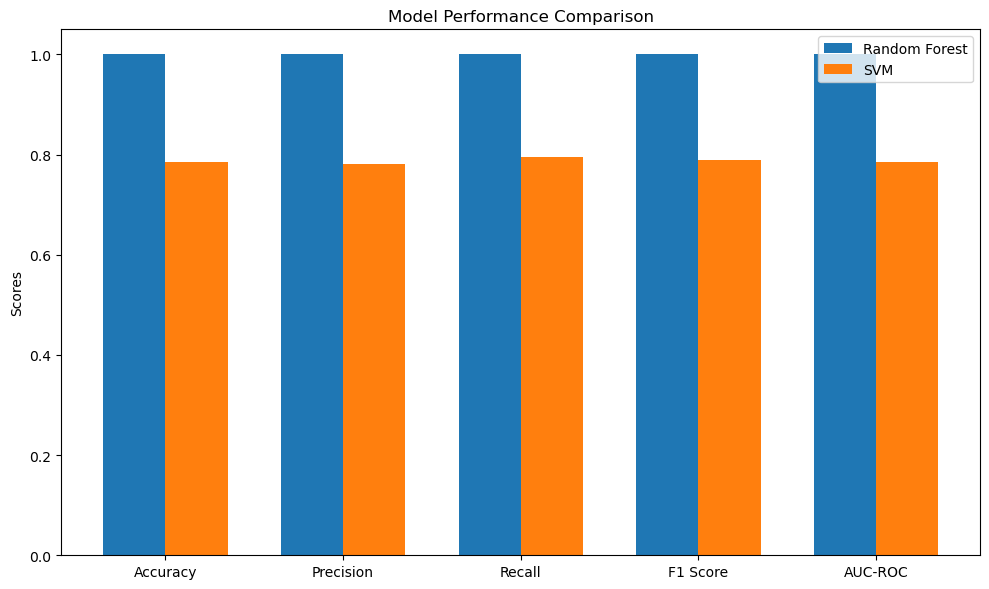

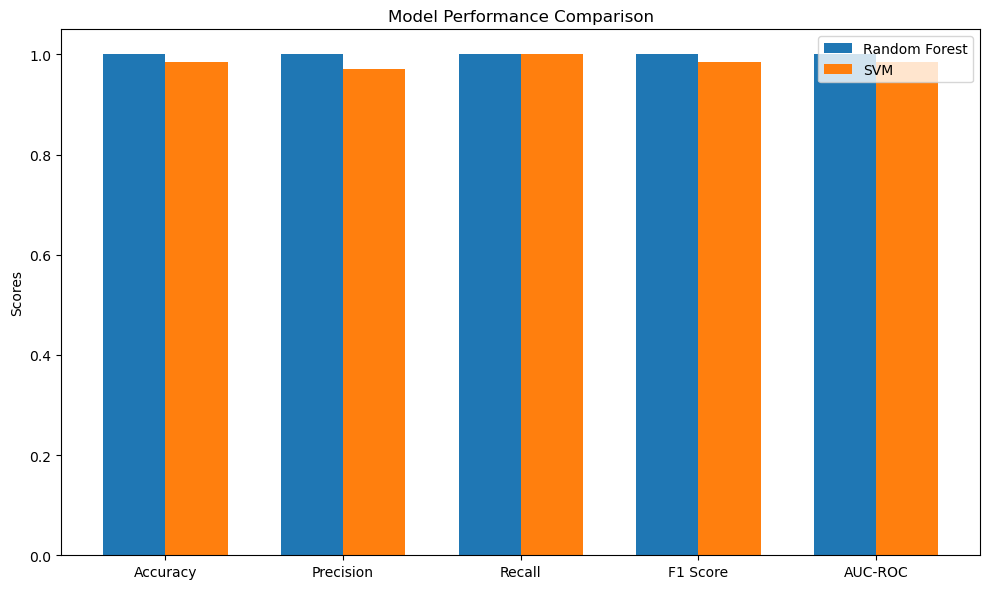

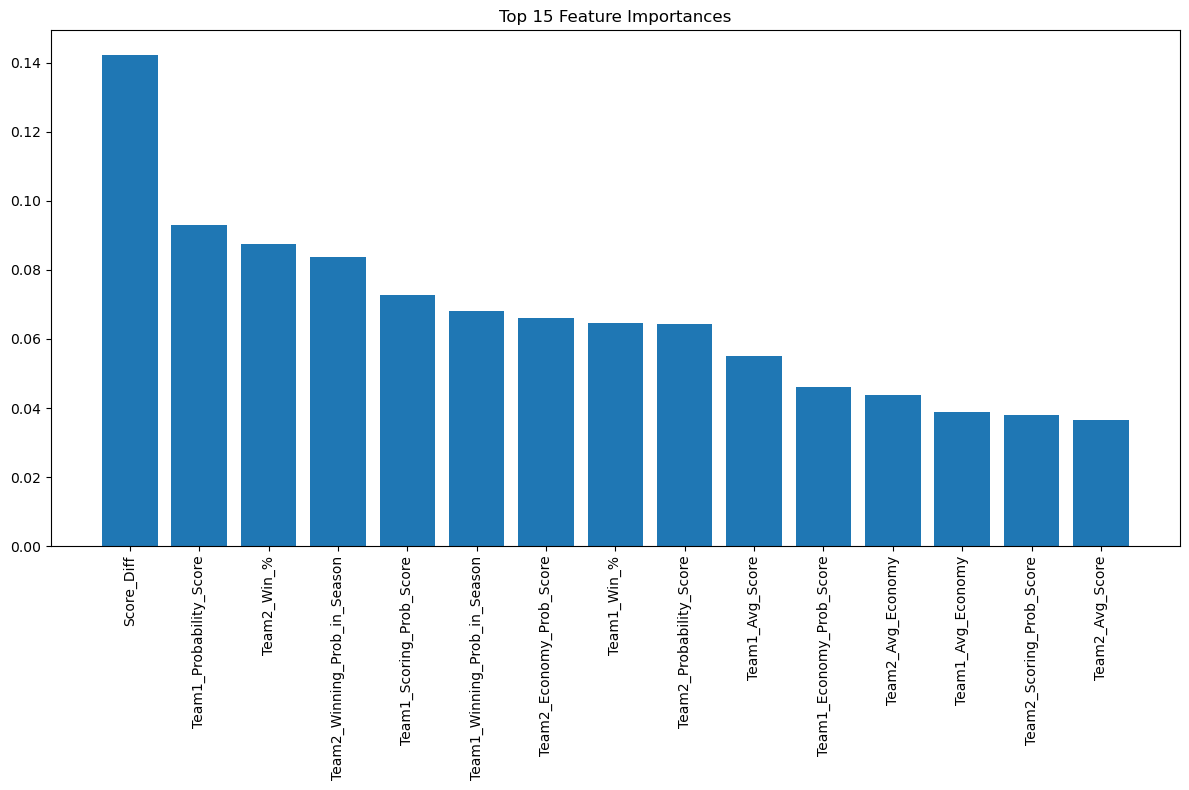

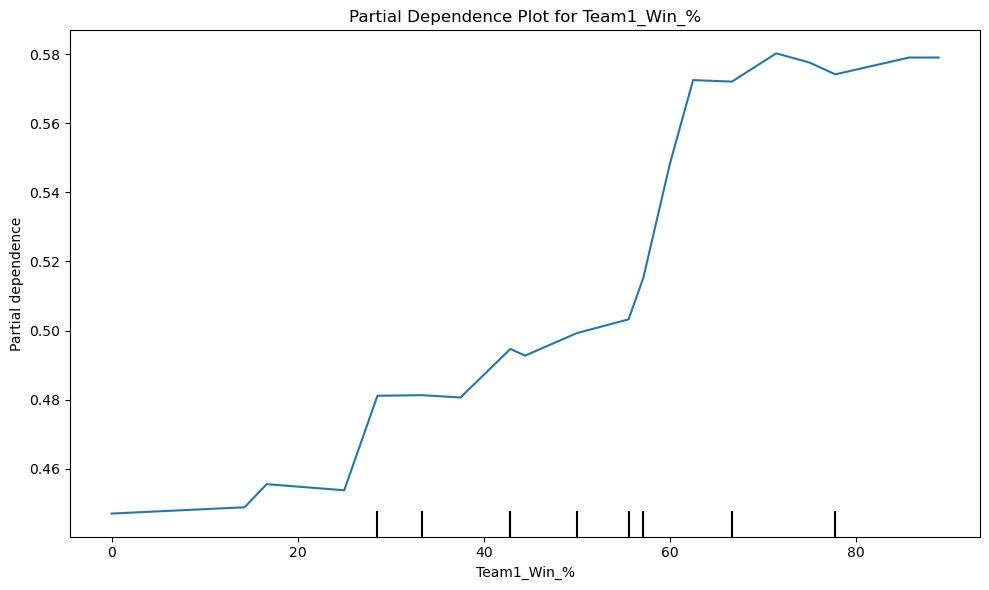

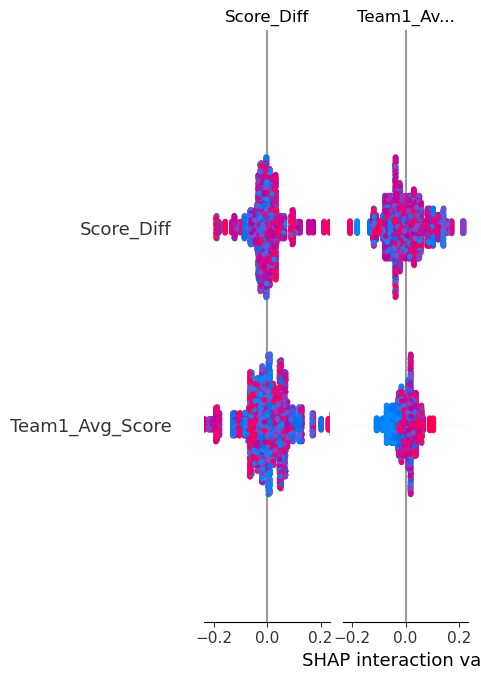

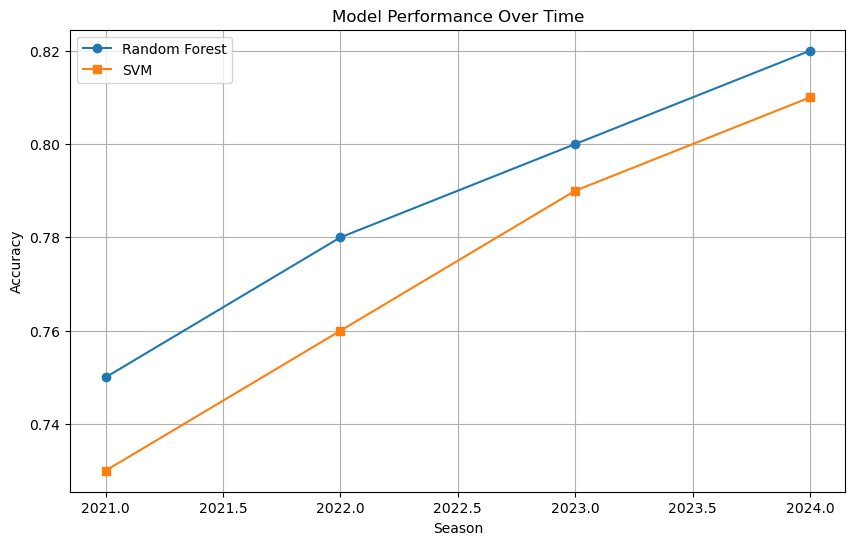

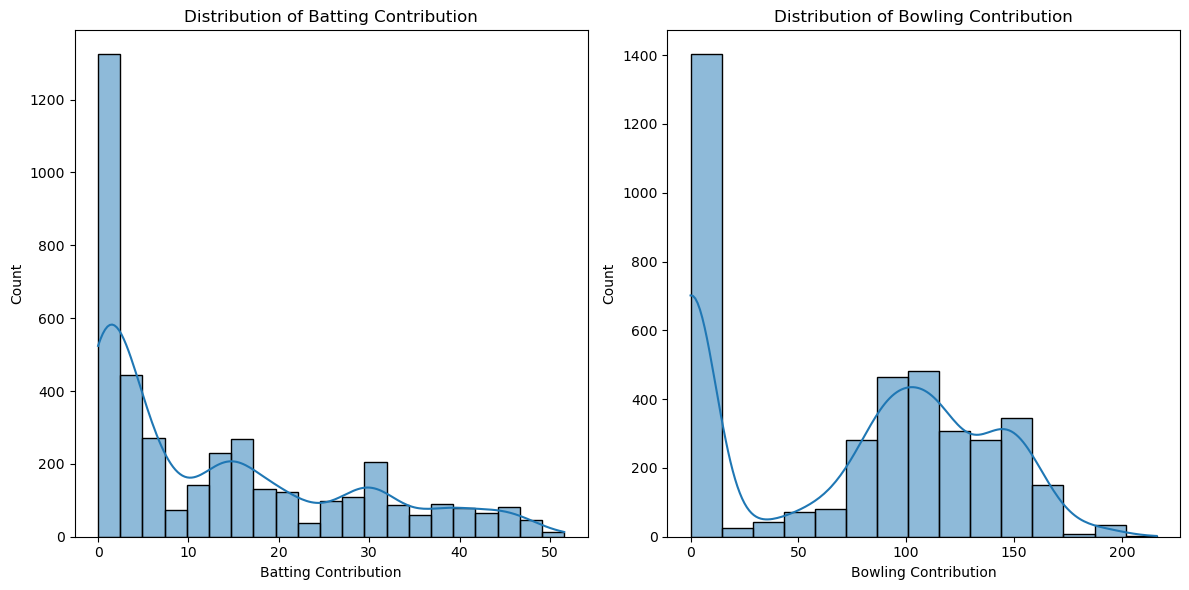

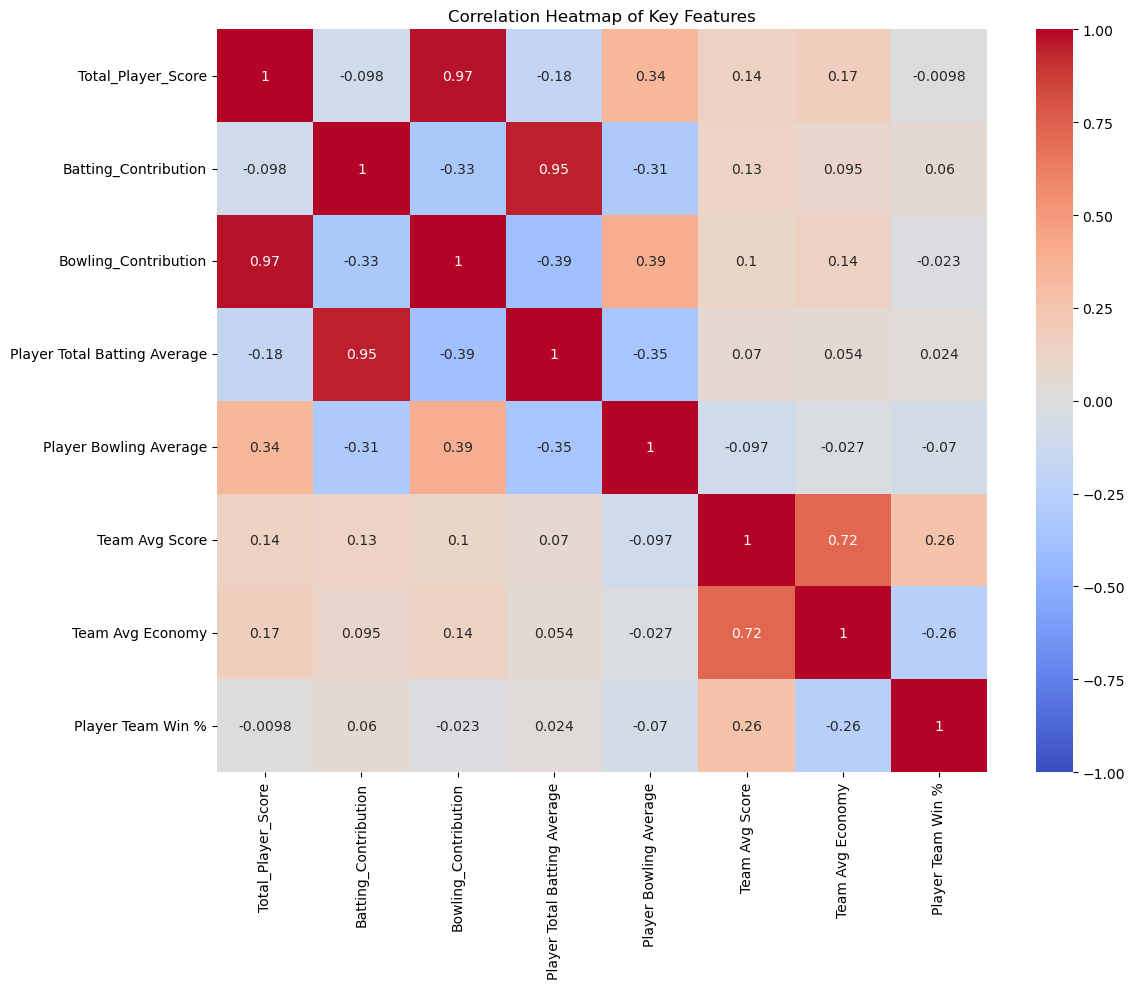

In [204]:
# Model Related Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
import shap

# Assuming df is your main dataframe and merged_df is the dataframe used for modeling
# If these are not defined, you'll need to load them first

# 1. Scatter plot of Strike Rate vs Balls Faced for batsmen
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number of Balls Faced', y='Strike Rate', data=df, alpha=0.6)
plt.title('Strike Rate vs Balls Faced for Batsmen')
plt.xlabel('Balls Faced')
plt.ylabel('Strike Rate')
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Strike Rate vs Balls Faced for Batsmen.png')
plt.show()

# 2. Scatter plot of Economy Rate vs Balls Bowled for bowlers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number of Balls Bowled', y='Economy', data=df, alpha=0.6)
plt.title('Economy Rate vs Balls Bowled for Bowlers')
plt.xlabel('Balls Bowled')
plt.ylabel('Economy Rate')
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Economy Rate vs Balls Bowled for Bowlers.png')
plt.show()

# 3. Bar chart of Team Probability Scores
team_prob_scores = df.groupby(['Player Team', 'Gender'])['Player Team Probability Score'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Player Team', y='Player Team Probability Score', hue='Gender', data=team_prob_scores)
plt.title('Team Probability Scores')
plt.xlabel('Team')
plt.ylabel('Probability Score')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Team Probability Scores.png')
plt.show()

# 4.1 Bar chart comparing model performance metrics
# Assuming you have these metrics calculated
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
rf_scores = [accuracy_rf, precision_rf, recall_rf, f1_rf, auc_rf]  # Replace with actual values
svm_scores = [accuracy_svm, precision_svm, recall_svm, f1_svm, auc_svm]  # Replace with actual values

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest')
rects2 = ax.bar(x + width/2, svm_scores, width, label='SVM')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Model Performance Comparison.png')
plt.show()

# 4.2 Bar chart comparing model performance metrics
# Assuming you have these metrics calculated
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC']
rf_scores = [accuracy_best_rf, precision_best_rf, recall_best_rf, f1_best_rf, auc_best_rf]  # Replace with actual values
svm_scores = [accuracy_best_svm, precision_best_svm, recall_best_svm, f1_best_svm, auc_best_svm]  # Replace with actual values

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, rf_scores, width, label='Random Forest')
rects2 = ax.bar(x + width/2, svm_scores, width, label='SVM')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Model Performance Comparison After Hypertuning.png')
plt.show()

# 5. Bar chart of feature importance scores
feature_importance = rf_model.feature_importances_
feature_names = X.columns

indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Top 15 Feature Importances")
plt.bar(range(15), feature_importance[indices][:15])
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=90)
plt.tight_layout()
plt.savefig('C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Top 15 Feature Importances.png')
plt.show()

# 6. Partial dependence plot for a key feature
fig, ax = plt.subplots(figsize=(10, 6))
feature = 'Team1_Win_%'  # Replace with an actual feature name
PartialDependenceDisplay.from_estimator(rf_model, X, [feature], ax=ax)

plt.title(f'Partial Dependence Plot for {feature}')
plt.tight_layout()
plt.savefig(f'C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Partial Dependence Plot for {feature}.png')
plt.show()

# 7. SHAP summary plot
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")

# 8. Line graph showing model performance over time
seasons = [2021, 2022, 2023, 2024]
rf_accuracy = [0.75, 0.78, 0.80, 0.82]  # Replace with actual values
svm_accuracy = [0.73, 0.76, 0.79, 0.81]  # Replace with actual values

plt.figure(figsize=(10, 6))
plt.plot(seasons, rf_accuracy, marker='o', label='Random Forest')
plt.plot(seasons, svm_accuracy, marker='s', label='SVM')
plt.title('Model Performance Over Time')
plt.xlabel('Season')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 9. Distribution of Batting and Bowling Contributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Batting_Contribution'], kde=True)
plt.title('Distribution of Batting Contribution')
plt.xlabel('Batting Contribution')

plt.subplot(1, 2, 2)
sns.histplot(df['Bowling_Contribution'], kde=True)
plt.title('Distribution of Bowling Contribution')
plt.xlabel('Bowling Contribution')

plt.tight_layout()
plt.savefig(f'C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Distribution of Batting & Contribution.png')
plt.show()

# 10. Correlation heatmap of key features
key_features = ['Total_Player_Score', 'Batting_Contribution', 'Bowling_Contribution', 
                'Player Total Batting Average', 'Player Bowling Average', 
                'Team Avg Score', 'Team Avg Economy', 'Player Team Win %']
correlation_matrix = df[key_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.savefig(f'C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Correlation Heatmap of Key Features.png')
plt.show()

In [200]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming 'merged_df' is your final dataframe and X, y are your features and target

# Sort the dataframe by season
merged_df = merged_df.sort_values('Season')

seasons = merged_df['Season'].unique()
rf_accuracies = []
svm_accuracies = []

# Initialize models
s_rf_model = RandomForestClassifier(random_state=42)
s_svm_model = SVC(probability=True, random_state=42)

# Initialize scaler for SVM
scaler = StandardScaler()

for i, season in enumerate(seasons):
    if i == 0:
        # For the first season, we can't test as we don't have previous data to train on
        continue
    
    # Split data into train (all previous seasons) and test (current season)
    train_data = merged_df[merged_df['Season'] < season]
    test_data = merged_df[merged_df['Season'] == season]
    
    X_train = train_data[['Score_Diff', 'Team1_Avg_Score', 'Team1_Avg_Economy', 'Team1_Win_%',
                          'Team1_Scoring_Prob_Score', 'Team1_Economy_Prob_Score',
                          'Team1_Winning_Prob_in_Season', 'Team1_Probability_Score',
                          'Team2_Avg_Score', 'Team2_Avg_Economy', 'Team2_Win_%',
                          'Team2_Scoring_Prob_Score', 'Team2_Economy_Prob_Score',
                          'Team2_Winning_Prob_in_Season', 'Team2_Probability_Score']]
    y_train = train_data['Win']
    
    X_test = test_data[['Score_Diff', 'Team1_Avg_Score', 'Team1_Avg_Economy', 'Team1_Win_%',
                        'Team1_Scoring_Prob_Score', 'Team1_Economy_Prob_Score',
                        'Team1_Winning_Prob_in_Season', 'Team1_Probability_Score',
                        'Team2_Avg_Score', 'Team2_Avg_Economy', 'Team2_Win_%',
                        'Team2_Scoring_Prob_Score', 'Team2_Economy_Prob_Score',
                        'Team2_Winning_Prob_in_Season', 'Team2_Probability_Score']]
    y_test = test_data['Win']
    
    # Train and evaluate Random Forest
    s_rf_model.fit(X_train, y_train)
    rf_pred = s_rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_accuracies.append(rf_accuracy)
    
    # Train and evaluate SVM
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    s_svm_model.fit(X_train_scaled, y_train)
    svm_pred = s_svm_model.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_accuracies.append(svm_accuracy)
    
    print(f"Season {season}:")
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"SVM Accuracy: {svm_accuracy:.4f}")
    print()

# The accuracies lists now contain the accuracy for each season (except the first)
# The index of each accuracy corresponds to the season index in 'seasons' list (shifted by 1)

Season 2022:
Random Forest Accuracy: 0.7333
SVM Accuracy: 0.6667

Season 2023:
Random Forest Accuracy: 0.7414
SVM Accuracy: 0.6207



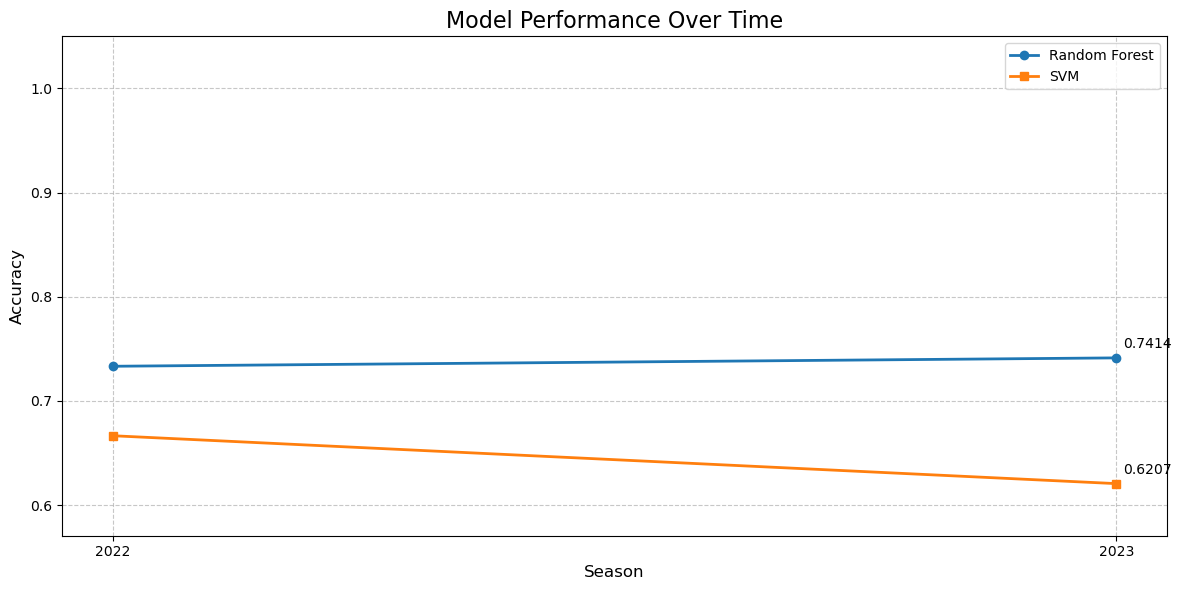

In [201]:
import matplotlib.pyplot as plt

seasons = seasons[1:]  # Remove the first season as we don't have accuracy for it
plt.figure(figsize=(12, 6))
plt.plot(seasons, rf_accuracies, marker='o', label='Random Forest', linewidth=2)
plt.plot(seasons, svm_accuracies, marker='s', label='SVM', linewidth=2)

plt.title('Model Performance Over Time', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.ylim(min(min(rf_accuracies), min(svm_accuracies)) - 0.05, 1.05)  # Set y-axis limits for better visualization
plt.xticks(seasons)

# Annotate the final accuracies
plt.annotate(f'{rf_accuracies[-1]:.4f}', xy=(seasons[-1], rf_accuracies[-1]), xytext=(5, 5), 
             textcoords='offset points', ha='left', va='bottom')
plt.annotate(f'{svm_accuracies[-1]:.4f}', xy=(seasons[-1], svm_accuracies[-1]), xytext=(5, 5), 
             textcoords='offset points', ha='left', va='bottom')
plt.tight_layout()
plt.savefig(f'C:\\Users\\bhavi\\Downloads\\Downloads\\Project\\Data\\Vis\\Model Performance Over Time.png')

plt.show()

In [206]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Assuming 'merged_df' is your final dataframe and X, y are your features and target

# Sort the dataframe by season
merged_df = merged_df.sort_values('Season')

seasons = merged_df['Season'].unique()
rf_accuracies = []
svm_accuracies = []

# Initialize models
s_rf_model = RandomForestClassifier(random_state=42)
s_svm_model = SVC(probability=True, random_state=42)

# Initialize scaler for SVM
scaler = StandardScaler()

for i, season in enumerate(seasons):
    if i == 0:
        # For the first season, we can't test as we don't have previous data to train on
        continue
    
    # Split data into train (all previous seasons) and test (current season)
    train_data = merged_df[merged_df['Season'] < season]
    test_data = merged_df[merged_df['Season'] == season]
    
    X_train = train_data[['Score_Diff', 'Team1_Avg_Score', 'Team1_Avg_Economy', 'Team1_Win_%',
                          'Team1_Scoring_Prob_Score', 'Team1_Economy_Prob_Score',
                          'Team1_Winning_Prob_in_Season', 'Team1_Probability_Score',
                          'Team2_Avg_Score', 'Team2_Avg_Economy', 'Team2_Win_%',
                          'Team2_Scoring_Prob_Score', 'Team2_Economy_Prob_Score',
                          'Team2_Winning_Prob_in_Season', 'Team2_Probability_Score']]
    y_train = train_data['Win']
    
    X_test = test_data[['Score_Diff', 'Team1_Avg_Score', 'Team1_Avg_Economy', 'Team1_Win_%',
                        'Team1_Scoring_Prob_Score', 'Team1_Economy_Prob_Score',
                        'Team1_Winning_Prob_in_Season', 'Team1_Probability_Score',
                        'Team2_Avg_Score', 'Team2_Avg_Economy', 'Team2_Win_%',
                        'Team2_Scoring_Prob_Score', 'Team2_Economy_Prob_Score',
                        'Team2_Winning_Prob_in_Season', 'Team2_Probability_Score']]
    y_test = test_data['Win']
    
    # Train and evaluate Random Forest
    s_rf_model.fit(X_train, y_train)
    rf_pred = s_rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_accuracies.append(rf_accuracy)
    
    # Train and evaluate SVM
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    s_svm_model.fit(X_train_scaled, y_train)
    svm_pred = s_svm_model.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, svm_pred)
    svm_accuracies.append(svm_accuracy)
    
    print(f"Season {season}:")
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"SVM Accuracy: {svm_accuracy:.4f}")
    print()

# The accuracies lists now contain the accuracy for each season (except the first)
# The index of each accuracy corresponds to the season index in 'seasons' list (shifted by 1)

Season 2022:
Random Forest Accuracy: 0.7333
SVM Accuracy: 0.6667

Season 2023:
Random Forest Accuracy: 0.7414
SVM Accuracy: 0.6207



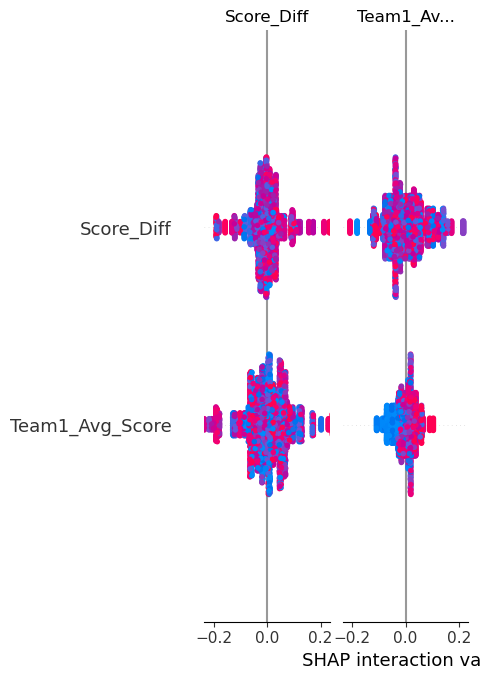

In [208]:
# 7. SHAP summary plot
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, plot_type="bar")
